In [157]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision = 3, suppress = True)

Generating data

In [158]:
gen_order = (3, 3)
a = [0, 0.22, -0.18, 0.08]
b = [0.5, 0.25, 0.25]

In [159]:
N = 100
v = np.random.randn(N+gen_order[1])

In [160]:
def make_series(a_coef, b_coef, order, n, mov_avg, noise_std = 0):
    y = [0]*order[0]
    for k in range(n):
        y.append(
            a_coef[0] +
            sum([a_coef[j]*y[order[0]+k-j] for j in range(1, order[0]+1)]) +
            mov_avg[order[1]+k] + 
            sum([b_coef[j-1]*mov_avg[order[1]+k-j] for j in range(1, order[1]+1)]) +
            np.random.randn()*noise_std
        )
    return np.array(y[order[0]:])

In [161]:
y = make_series(a_coef = a, b_coef = b, 
                order = gen_order, n = N,
                mov_avg = v, noise_std = 0.5)

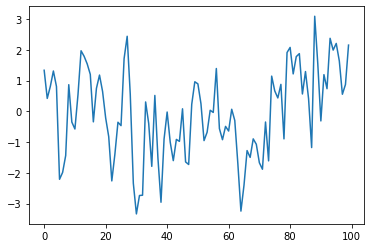

In [162]:
plt.plot(y)

In [176]:
def create_X(y, v, ARMA = (3, 3)):
    N = min(len(y)-ARMA[0], len(v)-ARMA[1])
    X = np.zeros((N, 2+ARMA[0]+ARMA[1]))
    X[:, 0] = np.ones((N, ))
    for j in range(ARMA[0]):
        X[:, ARMA[0]-j] = y[j:N+j]
    for j in range(ARMA[1]+1):
        X[:, ARMA[0]+ARMA[1]-j+1] = v[j:N+j]
    return X

МНК

In [177]:
def LS(X, y):
    coefs_history = []
    for i in range(len(y)):
        X_temp = X[:i+1]
        y_temp = y[:i+1]
        coefs_history.append(
            np.linalg.pinv(X_temp.T @ X_temp) @ X_temp.T @ y_temp
        )
    return coefs_history

РМНК

In [202]:
def RLS(X, y):
    n = X.shape[1]
    theta = np.zeros((n, 1))
    coefs_history = [theta.flatten()]
    P = 1e5 * np.eye(n)
    for i in range(len(y)):
        x = X[i].reshape((n, 1))
        temp = P @ x / (1 + x.T @ P @ x)
        theta += temp * (y[i] - x.T @ theta)
        coefs_history.append(theta.flatten())
        P = P - temp @ x.T @ P
    return coefs_history

In [178]:
ARMA = (3, 3)
X = create_X(y, v[gen_order[1]:], ARMA)

In [179]:
X[:5]

array([[ 1.   ,  0.81 ,  0.421,  1.336,  0.486,  1.018, -0.148,  0.391],
       [ 1.   ,  1.313,  0.81 ,  0.421,  0.489,  0.486,  1.018, -0.148],
       [ 1.   ,  0.808,  1.313,  0.81 , -3.091,  0.489,  0.486,  1.018],
       [ 1.   , -2.211,  0.808,  1.313, -0.01 , -3.091,  0.489,  0.486],
       [ 1.   , -1.987, -2.211,  0.808, -0.15 , -0.01 , -3.091,  0.489]])

In [199]:
LS_history = LS(X, y[gen_order[0]:])
res_LS = LS_history[-1]
res_LS[ARMA[1]+1] = 1

In [200]:
res_LS

array([-0.003,  0.315, -0.145,  0.078,  1.   ,  0.439,  0.19 ,  0.142])

In [205]:
RLS_history = RLS(X, y[gen_order[0]:])
res_RLS = RLS_history[-1]
res_RLS[ARMA[1]+1] = 1

In [206]:
res_RLS

array([-0.003,  0.315, -0.145,  0.078,  1.   ,  0.439,  0.19 ,  0.142])

In [183]:
a_new = res[:ARMA[0]+1]
b_new = res[ARMA[0]+2:]
y_new = make_series(a_coef = a_new, b_coef = b_new, 
                    order = ARMA, n = N, 
                    mov_avg = v)

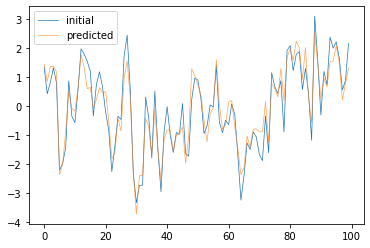

In [184]:
plt.plot(y, label = 'initial', lw = 0.7)
plt.plot(y_new, label = 'predicted', lw = 0.7, alpha = 0.7)
plt.legend()

In [173]:
def sum_squared_error(y_true, y_pred):
    return ((y_true - y_pred)**2).sum()

def r_squared(y_true, y_pred):
    return y_pred.var() / y_true.var()

def akaike(y_true, y_pred, ARMA):
    n = ARMA[0] + ARMA[1] +1
    N = y_true.size 
    return N * np.log(sum_squared_error(y_true,y_pred)) + 2*n

In [175]:
print(sum_squared_error(y, y_new))
print(r_squared(y, y_new))
print(akaike(y, y_new, ARMA))

20.9667631031894
0.8245092881238515
318.2938474543895
